In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm

In [4]:
df = pd.read_csv('../data/AB_NYC_2019.csv')

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.shape

(48895, 16)

In [7]:
# We transform latitude and longitude in UTM coordinates. Because the Earth portion at which we are looking is quite small, UTM provides enough accuracy.
df['utm'] = df.apply(lambda row : utm.from_latlon(row.latitude, row.longitude)[:2], axis=1)
df['utm_x'] = df.apply(lambda row : row.utm[0], axis=1)
df['utm_y'] = df.apply(lambda row : row.utm[1], axis=1)

In [8]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,utm,utm_x,utm_y
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,"(586884.7816290552, 4500133.886065807)",586884.781629,4.500134e+06
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,"(585784.6348931462, 4511903.790469252)",585784.634893,4.511904e+06
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,"(589244.9423654521, 4518095.410242636)",589244.942365,4.518095e+06
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,"(587901.5063912352, 4504325.790207911)",587901.506391,4.504326e+06
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,"(589082.7126969496, 4516926.585300169)",589082.712697,4.516927e+06


In [9]:
# Only taking a sample of the full dataframe, 50'000 Airbnb lead to too much computations.
seed = 1
n = 5000
df_red = df.sample(n, random_state=seed)

In [10]:
# Standardizing the UTM coordinates
df_coord = df_red[['utm_x', 'utm_y']]
df_coord.utm_x = (df_coord.utm_x - df_coord.utm_x.mean()) / df_coord.utm_x.std()
df_coord.utm_y = (df_coord.utm_y - df_coord.utm_y.mean()) / df_coord.utm_y.std()

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
df_coord.head()

,utm_x,utm_y
18907,1.552033,0.318589
46663,0.611587,0.545267
19757,-0.499501,-0.594698
9705,-0.013973,-0.087503
3322,-0.739066,-0.034959


In [12]:
# Computing distance between all airbnbs.
from scipy.spatial.distance import squareform, pdist
df_dist = pd.DataFrame(squareform(pdist(df_coord.iloc[:, 0:])), columns=df_coord.index, index=df_coord.index)

In [13]:
df_dist.head()

,18907,46663,19757,9705,3322,12637,19383,35358,28001,7201,...,31563,36874,31235,44418,31193,21368,7460,42535,20164,30115
18907,0.000000,0.967378,2.245636,1.617802,2.318217,2.000155,1.916462,0.416932,2.197895,1.445382,...,1.534015,1.768773,3.641113,1.087067,1.642654,0.475077,2.508805,2.333045,2.018593,5.043287
46663,0.967378,0.000000,1.591866,0.889788,1.470009,1.539570,1.568833,0.572471,1.740706,1.167579,...,1.028068,1.333986,4.475369,1.085788,0.756439,1.394046,1.994359,1.480805,1.081058,4.455214
19757,2.245636,1.591866,0.000000,0.702128,0.608851,0.471911,0.697936,1.870078,0.482089,0.944295,...,0.721539,0.601692,4.843246,1.354400,1.819492,2.454344,0.503605,0.626660,1.026413,2.864758
9705,1.617802,0.889788,0.702128,0.000000,0.726994,0.742290,0.861207,1.217125,0.920684,0.695474,...,0.370126,0.607234,4.623506,0.965480,1.211860,1.901564,1.129442,0.744723,0.686247,3.565820
3322,2.318217,1.470009,0.608851,0.726994,0.000000,1.024442,1.239005,1.906349,1.084363,1.316152,...,0.999339,1.057659,5.289166,1.661905,1.435241,2.625470,1.085602,0.020706,0.541453,3.121738


In [14]:
mean = df_dist.mean().mean()
print('The mean distance is {m}'.format(m=mean))

The mean distance is 1.6863646439513829


In [397]:
epsilon = 0
sigma = mean * 0.5
def sparsify(x):
    sigm_x = np.exp(- x**2 / (2*sigma**2))
    if sigm_x < epsilon:
        return 0
    return sigm_x

In [398]:
# compute weights of the edges, sparsifying.
df_dist_s = df_dist.applymap(sparsify)
print('there are {i} non-zero entries'.format(i = df_dist_s.astype(bool).sum().sum()))

there are 25000000 non-zero entries


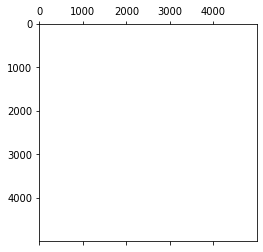

In [399]:
plt.spy(df_dist_s)
plt.show()

In [400]:
# create adjacency matrix, as a numpy array
adj = df_dist_s.values - np.eye(df_dist_s.shape[0])

In [401]:
adj

array([[0.00000000e+00, 5.17812350e-01, 2.88239876e-02, ...,
        2.17528077e-02, 5.69455227e-02, 1.70400942e-08],
       [5.17812350e-01, 0.00000000e+00, 1.68278992e-01, ...,
        2.13923461e-01, 4.39590488e-01, 8.66056505e-07],
       [2.88239876e-02, 1.68278992e-01, 0.00000000e+00, ...,
        7.58676638e-01, 4.76675168e-01, 3.11449570e-03],
       ...,
       [2.17528077e-02, 2.13923461e-01, 7.58676638e-01, ...,
        0.00000000e+00, 8.14573651e-01, 1.05701009e-03],
       [5.69455227e-02, 4.39590488e-01, 4.76675168e-01, ...,
        8.14573651e-01, 0.00000000e+00, 8.07708219e-05],
       [1.70400942e-08, 8.66056505e-07, 3.11449570e-03, ...,
        1.05701009e-03, 8.07708219e-05, 0.00000000e+00]])

In [53]:
# dictionnary to rename the labels of the nodes according to their indice in the df
nodes_labels = dict(zip(np.arange(n), df_dist_s.index))

In [179]:
# create networkx graph, renaming nodes
import networkx as nx
G = nx.from_numpy_matrix(adj)
G = nx.relabel_nodes(G, nodes_labels)

In [180]:
G.size()

277688

In [182]:
G.nodes()

NodeView((18907, 46663, 19757, 9705, 3322, 12637, 19383, 35358, 28001, 7201, 12619, 18737, 92, 15939, 14880, 3933, 29359, 36540, 19041, 30666, 20835, 26469, 7462, 39702, 23235, 37580, 8595, 44907, 24057, 33949, 46791, 41777, 85, 10410, 906, 4881, 46156, 21605, 30121, 26635, 15780, 46423, 46846, 12552, 31240, 391, 41772, 42523, 34538, 8678, 5698, 36059, 29820, 21748, 46989, 10220, 25379, 1226, 47464, 43170, 43092, 8464, 16500, 12649, 5055, 37718, 21913, 48262, 5730, 9446, 44746, 13429, 3367, 36320, 26942, 12945, 40704, 41054, 27363, 1215, 19646, 23550, 2727, 27872, 20394, 26516, 31320, 13561, 2956, 47277, 45583, 35998, 18253, 5893, 2648, 40793, 18575, 22459, 27411, 44784, 3298, 12290, 18767, 46865, 1113, 11618, 46949, 28877, 44721, 13539, 13801, 9131, 1620, 15588, 32522, 1169, 45097, 22351, 20509, 20762, 40653, 37647, 21393, 41693, 36837, 14214, 41055, 7904, 44642, 832, 14913, 25266, 45479, 40983, 17248, 40167, 21895, 16893, 14587, 47398, 931, 10155, 23528, 44576, 40770, 3015, 24279, 26

In [56]:
# create dictionnary for nodes positions
coord_dict = df_red.utm.to_dict()

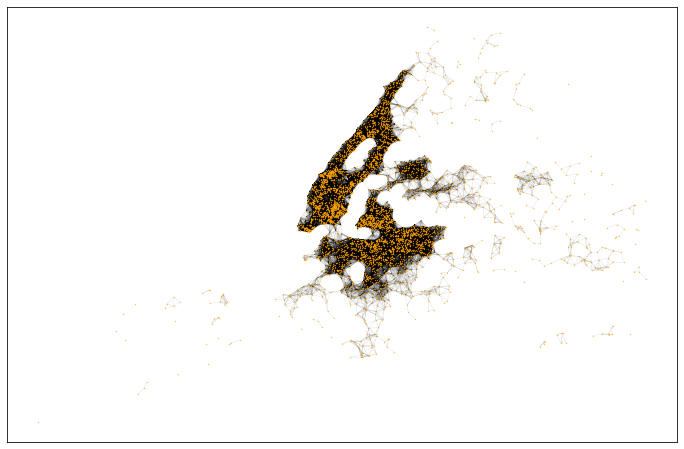

In [57]:
# graph of the airbnb
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05)
plt.show()

In [58]:
# different neighbourhood
df_red.neighbourhood_group.value_counts()

Manhattan        2175
Brooklyn         2061
Queens            611
Bronx             117
Staten Island      36
Name: neighbourhood_group, dtype: int64

In [59]:
neighbourhoud_to_int = {
    'Manhattan': 1,
    'Brooklyn': 2,
    'Queens': 3,
    'Bronx': 4,
    'Staten Island': 5
}

In [60]:
ground_truth_nei = df_red.neighbourhood_group.apply(lambda x: neighbourhoud_to_int.get(x)).values
ground_truth_nei[:5]

array([3, 3, 2, 2, 1])

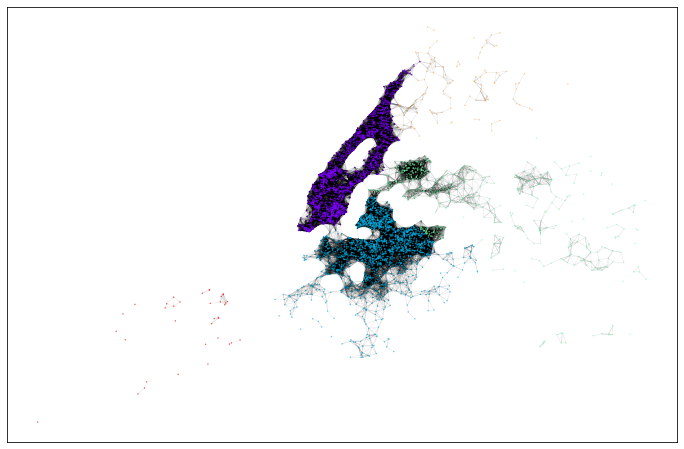

In [61]:
# graph of the airbnb with groundtruth
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=ground_truth_nei, width=0.05)
plt.show()

We keep only the biggest connected component

In [62]:
Gc = max(nx.connected_component_subgraphs(G), key=len)

In [63]:
Gc_nodes = max(nx.connected_components(G), key=len)

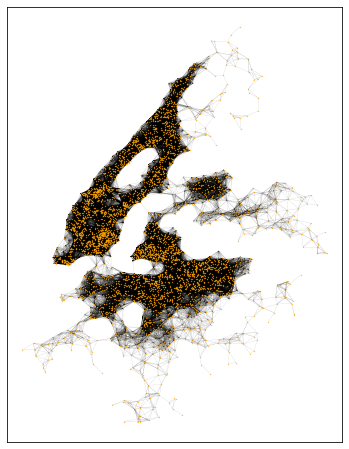

In [64]:
plt.figure(figsize=(6,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05)
plt.show()

Running spectral clustering on the biggest connected component

In [65]:
adj_c = nx.adjacency_matrix(Gc)

In [66]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=5, eigen_solver='amg', affinity='precomputed', n_init=100)
sc.fit(adj_c)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver='amg', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_init=100, n_jobs=None,
                   n_neighbors=10, random_state=None)

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


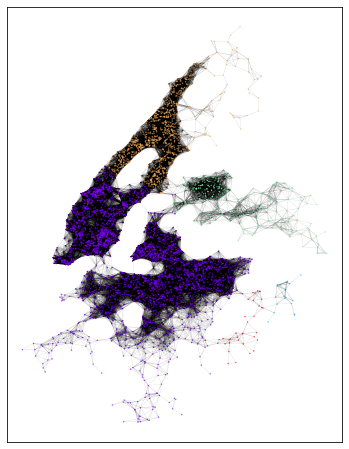

In [67]:
# displaying result of spectrcal clustering
plt.figure(figsize=(6,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=sc.labels_, width=0.05)
plt.show()

We can aslo try to run k-means, but it doesn't work well.

In [68]:
from sklearn.cluster import KMeans
km =  KMeans(n_clusters=5, init='k-means++', n_init=1, verbose=1)
km.fit(adj_c)

Initialization complete
Iteration  0, inertia 307544.608
Iteration  1, inertia 252078.346
Iteration  2, inertia 249525.134
Iteration  3, inertia 248232.815
Iteration  4, inertia 247334.392
Iteration  5, inertia 246774.728
Iteration  6, inertia 246514.530
Iteration  7, inertia 246457.747
Iteration  8, inertia 246423.051
Iteration  9, inertia 246409.757
Iteration 10, inertia 246404.467
Iteration 11, inertia 246401.799
Iteration 12, inertia 246399.142
Converged at iteration 12: center shift 0.000000e+00 within tolerance 1.393801e-06


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


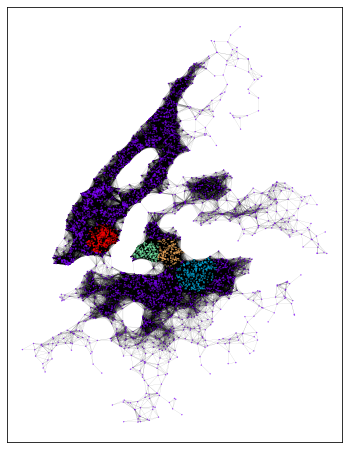

In [69]:
plt.figure(figsize=(6,8)) 
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=km.labels_, width=0.05)
plt.show()

Converting to a pygsp graph for analysing price and availibilty as signals over the graph

In [402]:
from pygsp import graphs, filters, plotting
from pygsp.graphs import Graph

In [403]:
G_gsp = graphs.Graph(adj)
print('{} nodes, {} edges'.format(G_gsp.N, G_gsp.Ne))

5000 nodes, 12497500 edges


In [404]:
G_gsp.is_connected()

True

In [405]:
G_gsp.set_coordinates(kind=np.array(list(coord_dict.values())))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


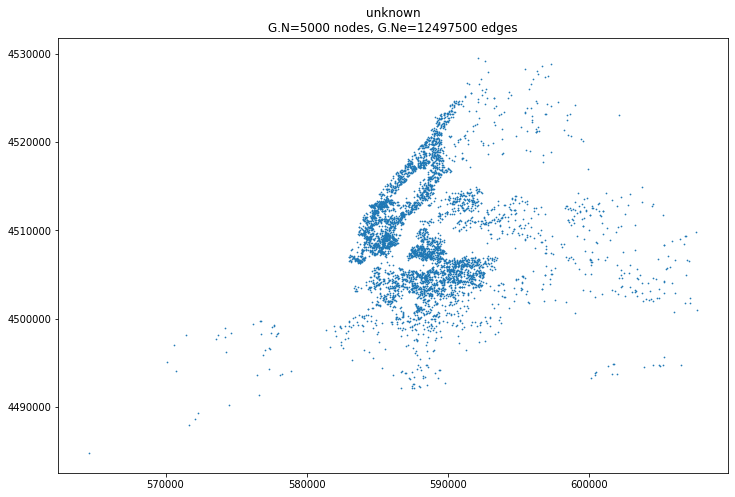

In [406]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
G_gsp.plot(vertex_size=0.5, backend='matplotlib', ax=axes)

In [407]:
# computing laplacian of graph
G_gsp.compute_laplacian(lap_type='combinatorial')

In [408]:
G_gsp.L

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 25000000 stored elements in Compressed Sparse Column format>

In [409]:
# computing eigendecomposition of the laplacian
G_gsp.compute_fourier_basis()

2019-12-17 15:36:27,728:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (5000 x 5000) may take some time.


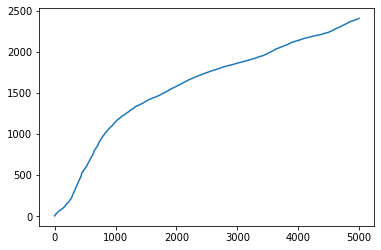

In [410]:
plt.plot(G_gsp.e)

In [425]:
G_gsp.U[:,20]

array([ 5.00118994e-05,  5.27539109e-05,  4.97634113e-05, ...,
        5.09088868e-05,  5.20286886e-05, -1.96870897e-02])

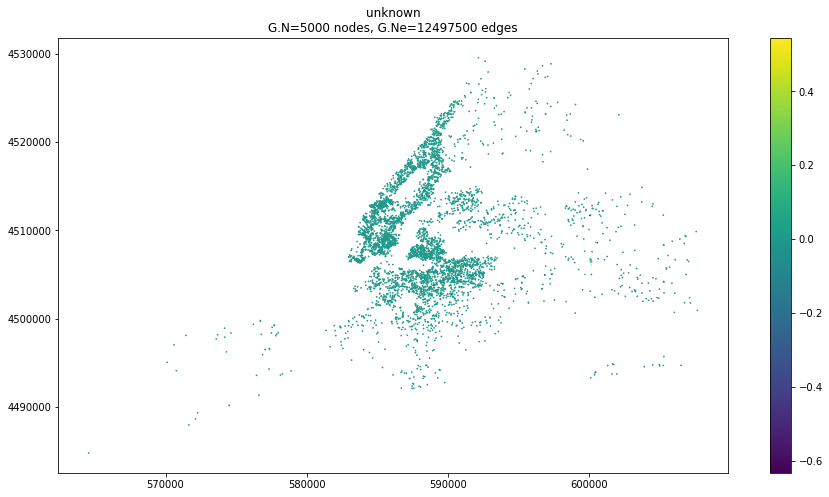

In [424]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=G_gsp.U[:,200],vertex_size=0.5,ax=axes)

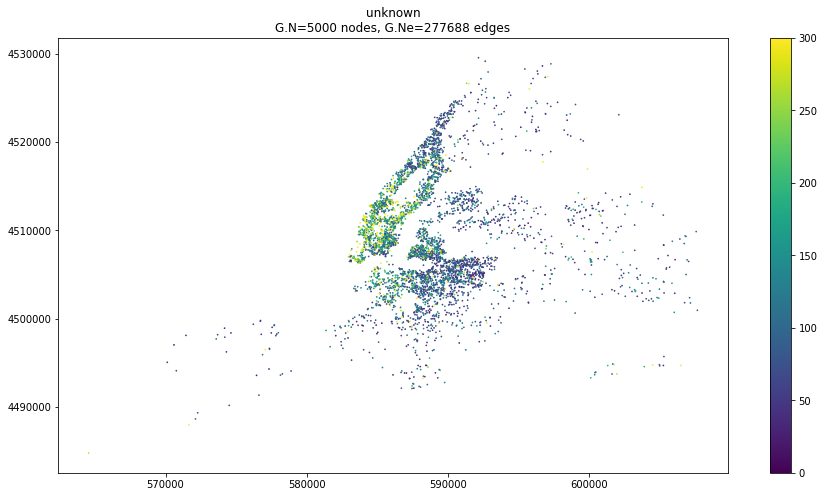

In [258]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price,vertex_size=0.5, limits=[0,300], ax=axes)